# Segment out the joints (red dots)

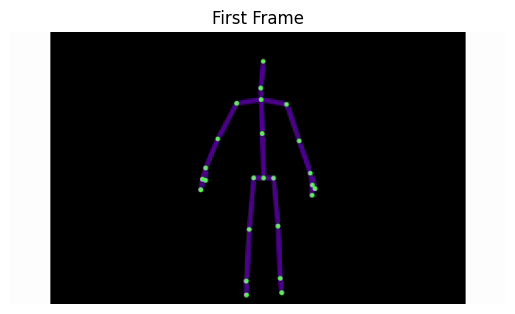

In [78]:
import cv2
from matplotlib import pyplot as plt

# Open the video file
cap = cv2.VideoCapture("../input/kinect-joints.mp4")

# Read the first frame
ret, frame = cap.read()
cap.release()

if ret:
  # Convert BGR (OpenCV default) to RGB for displaying with matplotlib
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  plt.imshow(frame_rgb)
  plt.axis('off')
  plt.title('First Frame')
  plt.show()
else:
  print("Failed to load the video or read the first frame.")

RGB threshold lower: [ 37 189  39]
RGB threshold upper: [137 255 139]


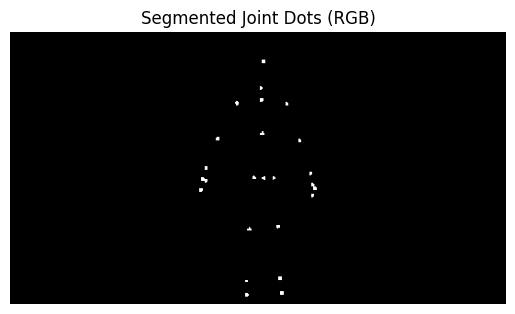

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Joint color
joint_rgb = np.array([87, 239, 89])  # (R, G, B)

# Set margin for thresholding (tune as needed)
margin = 50

lower = np.clip(joint_rgb - margin, 0, 255)
upper = np.clip(joint_rgb + margin, 0, 255)

print("RGB threshold lower:", lower)
print("RGB threshold upper:", upper)

# Create mask: pixels close to joint_rgb
mask = np.all((frame_rgb >= lower) & (frame_rgb <= upper), axis=-1)

plt.imshow(mask, cmap='gray')
plt.title("Segmented Joint Dots (RGB)")
plt.axis('off')
plt.show()

# Obtain the coords of each joint, relative to the top-left corner

In [80]:
# Find Contours of Green Dots

# Find contours in the mask
mask = (mask.astype(np.uint8)) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

dot_centers = []
min_area = 1  # Minimum area to filter out noise

for contour in contours:
    area = cv2.contourArea(contour)
    if area > min_area:
        M = cv2.moments(contour)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            dot_centers.append((cx, cy))

print(f"Found {len(dot_centers)} green dots.")

Found 23 green dots.


In [81]:
# Sort and Number the Dots

# Sort by y, then x for consistency
dot_centers_sorted = sorted(dot_centers, key=lambda p: (p[1], p[0]))

# Display the sorted coordinates
for idx, (x, y) in enumerate(dot_centers_sorted):
    print(f"Dot {idx}: (x={x}, y={y})")

Dot 0: (x=275, y=31)
Dot 1: (x=272, y=60)
Dot 2: (x=273, y=73)
Dot 3: (x=246, y=76)
Dot 4: (x=300, y=77)
Dot 5: (x=274, y=109)
Dot 6: (x=225, y=115)
Dot 7: (x=314, y=117)
Dot 8: (x=213, y=147)
Dot 9: (x=326, y=153)
Dot 10: (x=265, y=157)
Dot 11: (x=275, y=158)
Dot 12: (x=286, y=158)
Dot 13: (x=210, y=160)
Dot 14: (x=330, y=167)
Dot 15: (x=207, y=171)
Dot 16: (x=328, y=177)
Dot 17: (x=291, y=211)
Dot 18: (x=260, y=214)
Dot 19: (x=293, y=267)
Dot 20: (x=257, y=270)
Dot 21: (x=295, y=283)
Dot 22: (x=257, y=285)


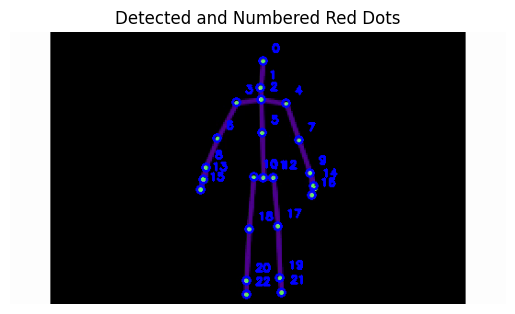

In [82]:
# Visualize the Numbered Dots on the Image

# Copy image for drawing
img_out = frame_rgb.copy()

# Draw green circles and numbers
for idx, (x, y) in enumerate(dot_centers_sorted):
    cv2.circle(img_out, (x, y), 4, (0, 0, 255), 2)
    cv2.putText(img_out, str(idx), (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 2)

# Show the result
plt.imshow(img_out)
plt.title("Detected and Numbered Red Dots")
plt.axis('off')
plt.show()

# Create image with transparent background

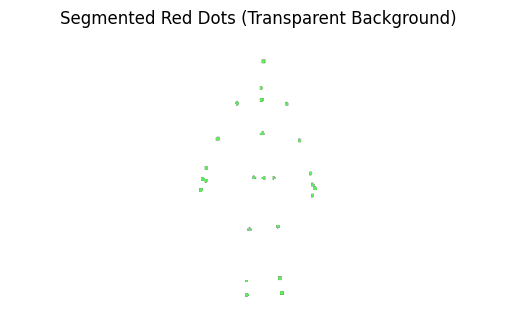

In [83]:
# Create an RGBA image with transparent background
img_rgba = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2RGBA)

# Set alpha channel: 255 where red_mask_clean > 0, 0 elsewhere
alpha_channel = np.where(mask > 0, 255, 0).astype(np.uint8)
img_rgba[..., 3] = alpha_channel

# Set RGB to 0 where not red dot (optional, for full transparency)
img_rgba[..., :3][alpha_channel == 0] = 0

plt.imshow(img_rgba)
plt.title("Segmented Red Dots (Transparent Background)")
plt.axis('off')
plt.show()

# Load the first frame of the clothing video

Frame2 shape: (296, 540, 3)
Frame2 dtype: uint8
Frame2 size (bytes): 479520


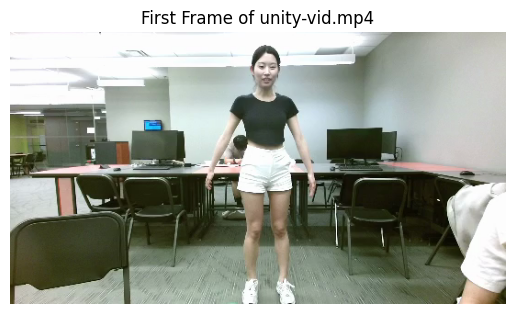

In [84]:
# Load the video file "unity-vid.mp4"
video2 = cv2.VideoCapture("../input/live-vid.mp4")

# Read the first frame
ret2, frame2 = video2.read()
video2.release()

if ret2:
  print("Frame2 shape:", frame2.shape)
  print("Frame2 dtype:", frame2.dtype)
  print("Frame2 size (bytes):", frame2.nbytes)
  # Convert BGR to RGB for display
  frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
  plt.imshow(frame2_rgb)
  plt.axis('off')
  plt.title("First Frame of unity-vid.mp4")
  plt.show()
else:
  print("Failed to read the first frame from unity-vid.mp4.")

# Overlay the joints on the clothing to show accuracy

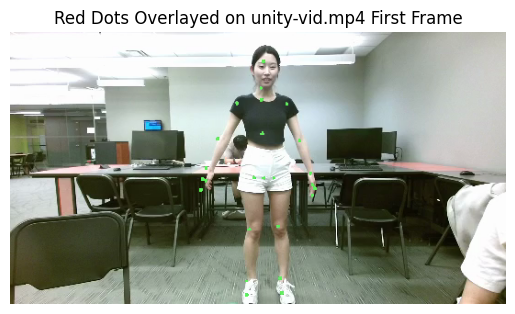

In [85]:
# Overlay img_rgba (red dots with transparency) onto frame2_rgb

# Ensure both images are the same size
assert img_rgba.shape[:2] == frame2_rgb.shape[:2], "Image sizes do not match!"

# Prepare output image as a copy of frame2_rgb
overlay_result = frame2_rgb.copy()

# Blend where alpha_channel > 0 (i.e., where red dots are)
alpha = img_rgba[..., 3] / 255.0  # Normalize alpha to [0,1]
for c in range(3):  # For R, G, B channels
  overlay_result[..., c] = (img_rgba[..., c] * alpha + overlay_result[..., c] * (1 - alpha)).astype(np.uint8)

plt.imshow(overlay_result)
plt.title("Red Dots Overlayed on unity-vid.mp4 First Frame")
plt.axis('off')
plt.show()